In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

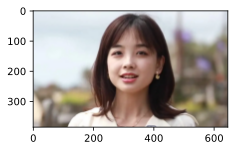

In [2]:
d2l.set_figsize()
img = d2l.Image.open('data/cs.png')
d2l.plt.imshow(img);

大多数图像增广方法都具有一定的随机性。为了便于观察图像增广的效果，我们下面定义辅助函数apply。 此函数在输入图像img上多次运行图像增广方法aug并显示所有结果

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

左右翻转图像通常不会改变对象的类别。这是最早且最广泛使用的图像增广方法之一。 接下来，我们使用transforms模块来创建RandomFlipLeftRight实例，这样就各有50%的几率使图像向左或向右翻转。

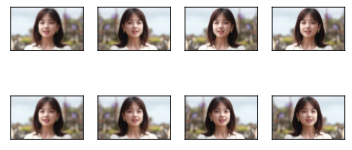

In [4]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

创建一个RandomFlipTopBottom实例，使图像各有50%的几率向上或向下翻转

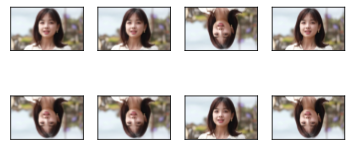

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())

在下面的代码中，我们随机裁剪一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5到2之间随机取值。 然后，区域的宽度和高度都被缩放到200像素。 在本节中（除非另有说明），a和b之间的随机数指的是在区间$[a,b]$中通过均匀采样获得的连续值。

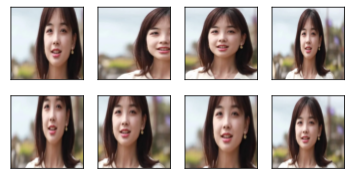

In [6]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

另一种增广方法是改变颜色。 我们可以改变图像颜色的四个方面：亮度、对比度、饱和度和色调。 在下面的示例中，我们随机更改图像的亮度，随机值为原始图像的50%（1 - 0.5）到150%（1 + 0.5）之间。

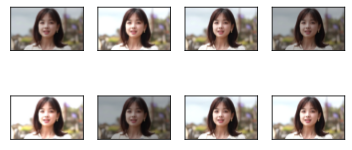

In [7]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

同样，我们可以随机更改图像的色调

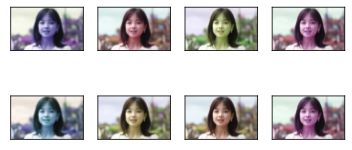

In [8]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

我们还可以创建一个RandomColorJitter实例，并设置如何同时随机更改图像的亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue）

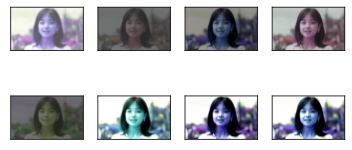

In [9]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

在实践中，我们将结合多种图像增广方法。比如，我们可以通过使用一个Compose实例来综合上面定义的不同的图像增广方法，并将它们应用到每个图像。

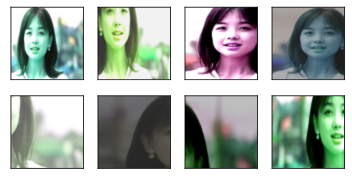

In [10]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

使用图像增广进行训练

让我们使用图像增广来训练模型。 这里，我们使用CIFAR-10数据集，而不是我们之前使用的Fashion-MNIST数据集。 这是因为Fashion-MNIST数据集中对象的位置和大小已被规范化，而CIFAR-10数据集中对象的颜色和大小差异更明显。 CIFAR-10数据集中的前32个训练图像如下所示

Using downloaded and verified file: ../data\cifar-10-python.tar.gz
Extracting ../data\cifar-10-python.tar.gz to ../data


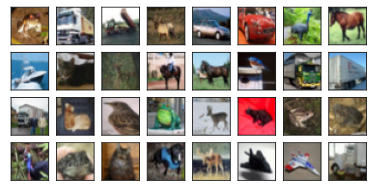

In [12]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，且在预测过程中不使用随机操作的图像增广。 在这里，我们只使用最简单的随机左右翻转。 此外，我们使用ToTensor实例将一批图像转换为深度学习框架所要求的格式，即形状为（批量大小，通道数，高度，宽度）的32位浮点数，取值范围为0到1。

In [13]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

定义一个辅助函数，以便于读取图像和应用图像增广。PyTorch数据集提供的transform函数应用图像增广来转化图像

In [14]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader